# Data collection

## [NASA Prediction of Worldwide Energy Resources (POWER)](https://aws.amazon.com/marketplace/pp/prodview-agetvmpkkzb7a?sr=0-1&ref_=beagle&applicationId=AWSMPContessa#resources)

In [2]:
'''
CODE BASED ON:
*Version: 1.0 Published: 2024/02/14* Source: [NASA POWER](https://power.larc.nasa.gov/)
POWER Remotely Connect to, Slice, and Download from a POWER Zarr via Python
This is an overview of the process to connect to and download from a POWER Zarr-formatted ARD via Python.
'''

import os
import fsspec

from datetime import datetime, timedelta

import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import regionmask

import matplotlib.pyplot as plt

import folium
from folium import Rectangle
import cartopy.crs as ccrs
import cartopy.feature as cfeature

%matplotlib inline

In [86]:
# Time range for daily data
start_date = '1981-01-01'
# end_date = '1981-01-03'

# start_date = '2023-01-01'
# end_date = '2023-12-31'

# This sets the end date to today's date
today = datetime.now()

# Subtracting 2 days from today's date
end_date_minus_2_days = today - timedelta(days=2)

# Converting to string in 'YYYY-MM-DD' format
end_date = end_date_minus_2_days.strftime('%Y-%m-%d')

# Geographic range covering Uganda and Kenya
lat_range = (-12, 22)  # South to North
lon_range = (23, 52)  # West to East

# Filepaths for different meteorological datasets with their corresponding variables
filepaths = {
    'https://power-analysis-ready-datastore.s3.us-west-2.amazonaws.com/power_901_daily_meteorology_utc.zarr': [
        'PRECTOTCORR', 'T2M', 'T2M', 'T2M_MAX', 'T2M_MIN', 'TS', 'PS', 'WS2M', 'WS10M', 'WS50M', 'QV2M', 'QV10M', 'RH2M', 'TQV', 'T2MDEW', 'T2MWET', 'DISPH',
         'RHOA', 'TO3', 'TROPPB', 'TROPQ', 'TROPT', 'U10M', 'U2M', 'U50M', 'V10M', 'V2M', 'V50M', 'WD10M', 'WD2M', 'WD50M', 'WS10M', 'WS2M', 'WS50M'
         #, 'GWETROOT', 'GWETPROF', 'GWETTOP', 'EVPTRNS'
    ]#,
    # 'https://power-analysis-ready-datastore.s3.us-west-2.amazonaws.com/power_901_daily_precipitation_utc.zarr': [
    #     'PRECIPITATIONCAL'
    # ],
    # 'https://power-analysis-ready-datastore.s3.us-west-2.amazonaws.com/power_901_daily_radiation_utc.zarr': [
    #     'CLOUD_AMT', 'ALLSKY_SFC_SW_DWN'
    # ]
}


In [87]:
def load_and_process_datasets(filepaths: dict, start_date: str, end_date: str, lat_range: tuple, lon_range: tuple) -> list:
    """
    Loads and processes multiple datasets from a dictionary of Zarr stores, selecting specific variables and slicing according to specified time, latitude, and longitude ranges.

    Parameters:
    - filepaths (dict): Dictionary with URLs to the Zarr stores as keys and lists of variable names as values.
    - start_date (str): Start date in the format YYYY-MM-DD.
    - end_date (str): End date in the format YYYY-MM-DD.
    - lat_range (tuple): Latitude range (start, end).
    - lon_range (tuple): Longitude range (start, end).

    Returns:
    - list: A list of xarray Datasets containing the selected and sliced data from each filepath.
    """
    datasets = []
    for filepath, variables in filepaths.items():
        filepath_mapped = fsspec.get_mapper(filepath)
        ds = xr.open_zarr(filepath_mapped, consolidated=True)
        ds_selected_all = {}
        
        for variable in variables:
            print(f"Downloading {variable} from {filepath}...")
            if variable in ds.data_vars:  # Ensure the variable exists in the dataset
                ds_selected_all[variable] = ds[variable].sel(
                    time=pd.date_range(start=start_date, end=end_date, freq='D'),
                    lat=slice(*lat_range),
                    lon=slice(*lon_range)
                ).load()

        if ds_selected_all:
            ds_combined = xr.Dataset(ds_selected_all)
            datasets.append(ds_combined)
    
    return datasets

# Load and process each dataset by specifying filepaths and variables
datasets = load_and_process_datasets(filepaths, start_date, end_date, lat_range, lon_range)

In [88]:
datasets[0]

<xarray.Dataset> Size: 12GB
Dimensions:      (lat: 69, lon: 47, time: 15840)
Coordinates:
  * lat          (lat) float64 552B -12.0 -11.5 -11.0 -10.5 ... 21.0 21.5 22.0
  * lon          (lon) float64 376B 23.12 23.75 24.38 25.0 ... 50.62 51.25 51.88
  * time         (time) datetime64[ns] 127kB 1981-01-01 ... 2024-05-14
Data variables: (12/30)
    PRECTOTCORR  (time, lat, lon) float64 411MB 4.54e-05 6.572e-05 ... 0.0 0.0
    T2M          (time, lat, lon) float64 411MB 294.4 293.2 ... 307.1 307.1
    T2M_MAX      (time, lat, lon) float64 411MB 298.7 297.6 ... 314.7 314.6
    T2M_MIN      (time, lat, lon) float64 411MB 290.7 289.6 ... 299.2 299.3
    TS           (time, lat, lon) float64 411MB 294.1 293.0 ... 308.5 308.6
    PS           (time, lat, lon) float64 411MB 8.828e+04 ... 9.934e+04
    ...           ...
    V10M         (time, lat, lon) float64 411MB 1.164 1.648 1.695 ... 4.117 4.5
    V2M          (time, lat, lon) float64 411MB 0.6484 0.9922 ... 3.164 3.477
    V50M         (time, lat, lon) float64 411MB 1.906 2.68 2.68 ... 5.648 6.062
    WD10M        (time, lat, lon) float64 411MB 118.3 120.2 ... 146.4 143.5
    WD2M         (time, lat, lon) float64 411MB 118.2 120.3 ... 146.4 143.6
    WD50M        (time, lat, lon) float64 411MB 118.2 120.1 ... 146.5 143.6

In [92]:
dataset = datasets[0]

In [93]:
dataset

<xarray.Dataset> Size: 12GB
Dimensions:      (lat: 69, lon: 47, time: 15840)
Coordinates:
  * lat          (lat) float64 552B -12.0 -11.5 -11.0 -10.5 ... 21.0 21.5 22.0
  * lon          (lon) float64 376B 23.12 23.75 24.38 25.0 ... 50.62 51.25 51.88
  * time         (time) datetime64[ns] 127kB 1981-01-01 ... 2024-05-14
Data variables: (12/30)
    PRECTOTCORR  (time, lat, lon) float64 411MB 4.54e-05 6.572e-05 ... 0.0 0.0
    T2M          (time, lat, lon) float64 411MB 294.4 293.2 ... 307.1 307.1
    T2M_MAX      (time, lat, lon) float64 411MB 298.7 297.6 ... 314.7 314.6
    T2M_MIN      (time, lat, lon) float64 411MB 290.7 289.6 ... 299.2 299.3
    TS           (time, lat, lon) float64 411MB 294.1 293.0 ... 308.5 308.6
    PS           (time, lat, lon) float64 411MB 8.828e+04 ... 9.934e+04
    ...           ...
    V10M         (time, lat, lon) float64 411MB 1.164 1.648 1.695 ... 4.117 4.5
    V2M          (time, lat, lon) float64 411MB 0.6484 0.9922 ... 3.164 3.477
    V50M         (time, lat, lon) float64 411MB 1.906 2.68 2.68 ... 5.648 6.062
    WD10M        (time, lat, lon) float64 411MB 118.3 120.2 ... 146.4 143.5
    WD2M         (time, lat, lon) float64 411MB 118.2 120.3 ... 146.4 143.6
    WD50M        (time, lat, lon) float64 411MB 118.2 120.1 ... 146.5 143.6

In [17]:
def visualize_area(lat_range, lon_range):
    """
    Visualizes a specified area on a map using Folium.

    Parameters:
    - lat_range (tuple): A tuple of (min_latitude, max_latitude) for the area.
    - lon_range (tuple): A tuple of (min_longitude, max_longitude) for the area.

    Returns:
    - A Folium Map object centered around the midpoint of the specified area with a rectangle overlay of the area.
    """
    # Calculate the center of the area
    center_lat = (lat_range[0] + lat_range[1]) / 2
    center_lon = (lon_range[0] + lon_range[1]) / 2

    # Create a Folium map centered around the calculated midpoint
    map_centered = folium.Map(location=[center_lat, center_lon], zoom_start=6)

    # Define the bounds of the rectangle for the specified area
    bounds = [(lat_range[0], lon_range[0]), (lat_range[1], lon_range[1])]

    # Create a rectangle overlay and add it to the map
    folium.Rectangle(bounds=bounds, color='#ff7800', fill=True, fill_opacity=0.2).add_to(map_centered)

    # Display the map
    return map_centered

In [18]:
# Visualize the area
map_visualization = visualize_area(lat_range, lon_range)

# To display the map in a Jupyter Notebook, simply call the map object
map_visualization

In [90]:
def regrid_datasets(datasets, new_lat_res=0.5, new_lon_res=0.625):
    """
    Regrids a list of xarray datasets to a common specified latitude and longitude grid.

    Parameters:
    - datasets (list of xr.Dataset): List of xarray datasets to be regridded.
    - new_lat_res (float): The new resolution for latitude.
    - new_lon_res (float): The new resolution for longitude.

    Returns:
    - list of xr.Dataset: A list containing the regridded datasets.

    Example of usage:
    regridded_datasets = regrid_datasets(my_datasets)
    """
    # Calculate the global min and max of latitude and longitude across all datasets
    lat_min = min([ds.lat.min() for ds in datasets])
    lat_max = max([ds.lat.max() for ds in datasets])
    lon_min = min([ds.lon.min() for ds in datasets])
    lon_max = max([ds.lon.max() for ds in datasets])

    # Create common latitude and longitude grids
    common_lat = np.arange(lat_min, lat_max + new_lat_res, new_lat_res)
    common_lon = np.arange(lon_min, lon_max + new_lon_res, new_lon_res)

    regridded_datasets = []
    for ds in datasets:
        # Interpolate dataset to the new common grid
        regridded_ds = ds.interp(lat=common_lat, lon=common_lon, method='linear', kwargs={"fill_value": "extrapolate"})
        regridded_datasets.append(regridded_ds)
    
    return regridded_datasets

# Usage example (assuming datasets is your list of datasets)
# regridded_datasets = regrid_datasets(datasets)

In [91]:
def merge_datasets(datasets):
    """
    Merges multiple xarray datasets into a single dataset.

    Parameters:
    - datasets (list of xr.Dataset): List of xarray datasets to merge.

    Returns:
    - xr.Dataset: A single merged dataset.

    Example of usage:
    merged_dataset = merge_datasets(regridded_datasets)
    """
    # Merge the datasets using xarray's merge function
    # The 'compat' parameter is set to 'no_conflicts' to allow merging without conflicts
    # The 'join' parameter is set to 'outer' to use the union of indexes from all datasets
    return xr.merge(datasets, compat='no_conflicts', join='outer')

# Usage example (assuming regridded_datasets is your list of regridded datasets)
# merged_dataset = merge_datasets(regridded_datasets)

In [96]:
def plot_lat_lon_grids_with_borders(ds, time_index=0, variable=None, zoom_factor=1):
    """
    Plots the lat/lon grid points of an xarray.Dataset on a map with country borders,
    for a given time index, and dynamically adjusts the zoom to the dataset's area.
    Grid points are colored from a palette based on their index.

    Parameters:
    - ds (xarray.Dataset): The input dataset.
    - time_index (int): The time index to plot. Defaults to the first time index (0).
    - variable (str): The name of the variable to plot. If None, only the grid points will be plotted.
    - zoom_factor (float): A multiplier to adjust the map's zoom level. Default is 1 for no adjustment.

    Example of usage:
    - plot_lat_lon_grids_with_borders(masked_dataset, time_index=0, variable='CDD0')
    """
    # Determine the extent based on the dataset's latitude and longitude
    lat_min, lat_max = np.min(ds.lat.values), np.max(ds.lat.values)
    lon_min, lon_max = np.min(ds.lon.values), np.max(ds.lon.values)
    
    # Apply zoom factor
    lat_range = (lat_max - lat_min) * zoom_factor
    lon_range = (lon_max - lon_min) * zoom_factor
    mid_lat = (lat_max + lat_min) / 2
    mid_lon = (lon_max + lon_min) / 2
    extent = [mid_lon - lon_range/2, mid_lon + lon_range/2, mid_lat - lat_range/2, mid_lat + lat_range/2]

    # Create the figure and axis with a PlateCarree projection
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    # Add geographical features
    ax.add_feature(cfeature.BORDERS)
    ax.coastlines()

    # Plot the variable if specified
    if variable is not None and variable in ds.data_vars:
        im = ax.pcolormesh(ds.lon.values, ds.lat.values, ds[variable].isel(time=time_index),
                           shading='auto', transform=ccrs.PlateCarree(), cmap='viridis')
        plt.colorbar(im, ax=ax, shrink=0.5, label=variable)

    # Plot grid points
    lon2d, lat2d = np.meshgrid(ds.lon.values, ds.lat.values)
    num_points = lon2d.size
    colors = plt.cm.viridis(np.linspace(0, 1, num_points))

    plt.title(f'{variable if variable else "Grid Points"} at Time Index {time_index}')
    plt.show()

# Example call to function with additional arguments if needed
# plot_lat_lon_grids_with_borders(dataset, time_index=0, variable='CDD0', zoom_factor=1.5)


In [97]:
# plot_lat_lon_grids_with_borders(merged_dataset, time_index=0, variable='PRECTOTCORR', zoom_factor=1.5)

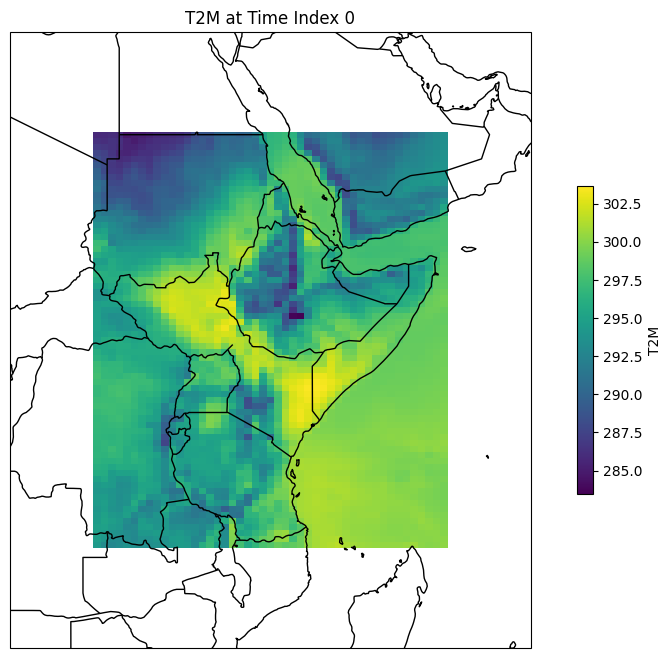

In [99]:
# temperature in Kelvins
plot_lat_lon_grids_with_borders(dataset, time_index=0, variable='T2M', zoom_factor=1.5)

In [23]:
# # Define compression settings
# compression_opts = {'zlib': True, 'complevel': 5}  # You can adjust the compression level from 1 to 9

# # Apply the compression to each variable in the dataset
# encoding = {var: compression_opts for var in merged_dataset.variables}

# # Export the region as a compressed NetCDF4 file
# merged_dataset.to_netcdf(
#     path=os.path.join("/workspace/soil-ml-modeling-pipeline/ml-modeling-pipeline/data/01_raw/power_nasa_data.nc"),
#     encoding=encoding
# )


In [101]:
# Define compression settings
compression_opts = {'zlib': True, 'complevel': 5}  # You can adjust the compression level from 1 to 9

# Apply the compression to each variable in the dataset
encoding = {var: compression_opts for var in dataset.variables}

# Export the region as a compressed NetCDF4 file
dataset.to_netcdf(
    path=os.path.join("/workspace/soil-ml-modeling-pipeline/ml-modeling-pipeline/data/01_raw/power_nasa_data.nc"),
    encoding=encoding
)

In [ ]:
# merged_ds.to_netcdf("/workspace/soil-ml-modeling-pipeline/ml-modeling-pipeline/data/01_raw/power_nasa_data.nc")